## 2 DETEKTERING AV CELLEKJERNER

In [121]:
%matplotlib notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
from PIL import Image
from imageio import imread 

In [122]:
import numpy as np
from matplotlib import pyplot as plt
import imageio
import math 
import time
import numba
from numba import jit, prange

In [123]:
image_input = imread('Data/cellekjerner.png',as_gray = True) 

print(image_input.shape)
M,N = image_input.shape

(1040, 1388)


<IPython.core.display.Javascript object>


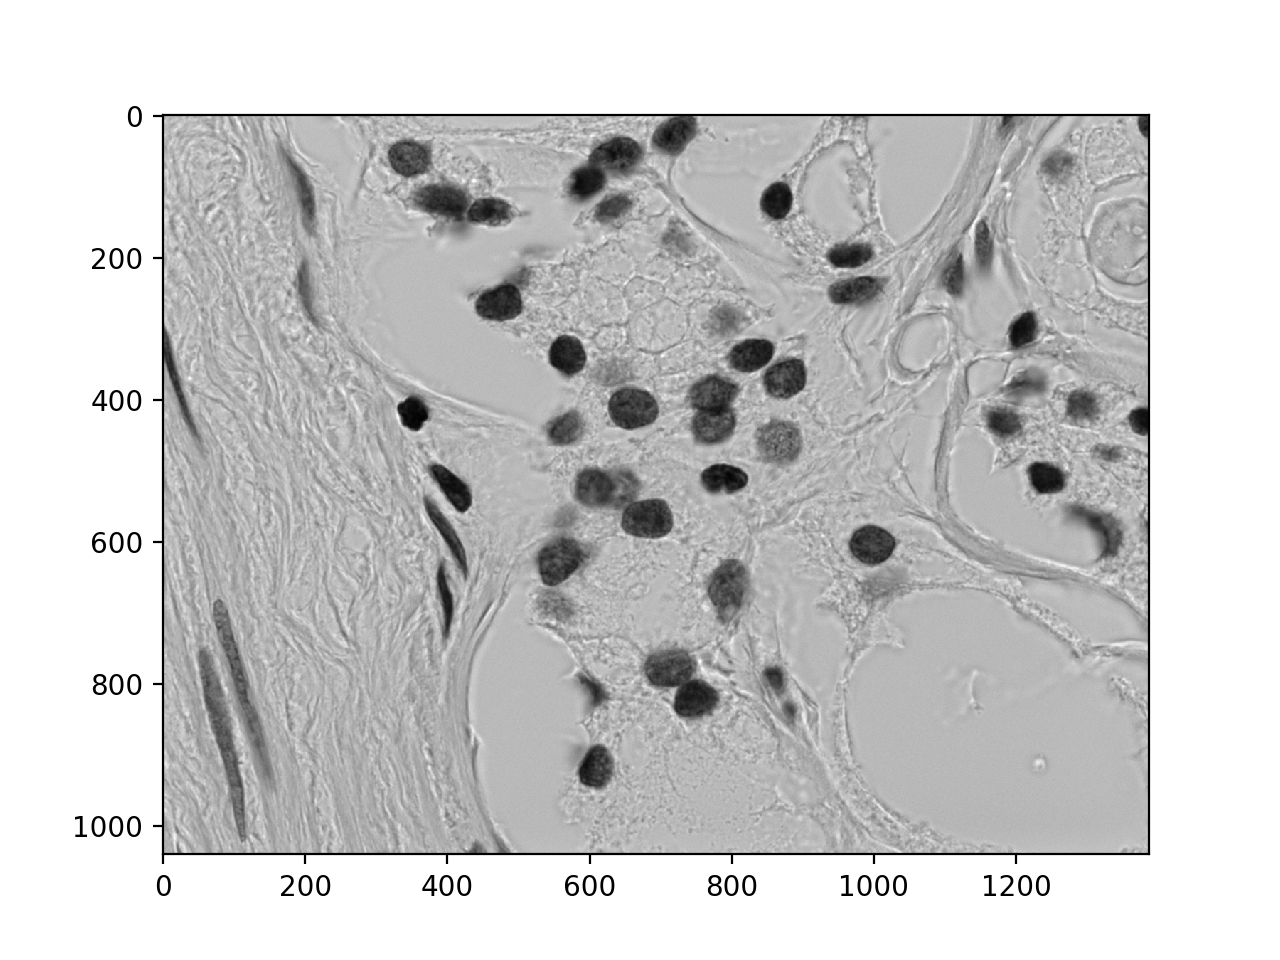

In [124]:
plt.figure()
plt.imshow(image_input, cmap='gray')

### Funksjon for bilde med ramme - input bilde, maskens sider m, n: 

In [125]:
def pad_image(image_input,m,n):

    M,N = image_input.shape    
    
    # definerer bilde med rett ramme: 
    image_input_pad = np.zeros((M+m-1,N+n-1)) 
    
    # Finner senter 
    r_2 = np.round((m-1)/2).astype(int)
    c_2 = np.round((n-1)/2).astype(int)

    #Definerer hjørnene i rammebildet: 
    image_input_pad[0:r_2,0:c_2] = image_input[0,0] 
    image_input_pad[0:r_2,N+c_2:N+2*c_2+1] = image_input[0,N-1]
    image_input_pad[M+r_2:M+2*r_2+1,0:c_2] = image_input[M-1,0]
    image_input_pad[M+r_2:M+2*r_2+1,N+c_2:N+2*c_2+1] = image_input[M-1,N-1]

    #definerer sidene: 
    image_input_pad[0:r_2,c_2:N+c_2] = image_input[0,:]
    image_input_pad[r_2+M:M+m-1, c_2:N+c_2] = image_input[M-1,:]
    image_input_pad[r_2:M+r_2, 0:c_2] = image_input[:,0].reshape(-1,1) 
    image_input_pad[r_2:M+r_2, c_2:N+n-1 ] = image_input[:, N-1].reshape(-1,1)

    #resten av bildet: 
    image_input_pad[r_2:M+r_2,c_2:N+c_2] = image_input[:,:]

    return image_input_pad

### Oppgave 2a) Konvolusjons funksjon 

In [126]:
def convolution(image, image_filter):
    M,N = image.shape
    #Roterer filteret 180 grader (samme når filteret er symmetrisk )
    image_filter = np.rot90(image_filter, 2)
    
    #henter sidene til filteret.  
    w_row, w_col = image_filter.shape
    
    # image pad 
    image = pad_image(image, w_row,w_col)    
    image_row, image_col = image.shape 
    
    # finner senter av filteret 
    r = np.round(((w_row-1)/2)).astype(int)
    c = np.round(((w_col-1)/2)).astype(int)
 
    #Definerer outputbilde 
    conv_output = np.zeros((M,N))
    
    for row in range(r,image_row - r): 
        for col in range(c, image_col - c): 
            conv_output[row-r,col-c] = np.sum(np.multiply(image[row-r:row+r+1, col-c:col+c+1],image_filter))
    return conv_output 

### Oppgave 2b) Opprette Gaussfilter 



In [127]:
def gaussFilter(sigma): #(x,y,sigma): 
    #sigma = 2
    x = np.round(((sigma*8)+1)).astype(int)
    y = x
    hysterese_gauss = np.zeros((x,y))
    
    sigma_const = 1 / (2*sigma**2)
    #print(sigma_const/math.pi)
    
    # finner filterets senter:  
    r = np.round(((x-1)/2)).astype(int)
    c = np.round(((y-1)/2)).astype(int)

    A = 0

    for row in range(-r, r+1): 
        for col in range(-c,  c+1): 
            hysterese_gauss[row+r,col+c] = np.exp(-(row**2+col**2)*sigma_const) 
            A += hysterese_gauss[row+r,col+c]   
    print(1/A)
    print(sigma_const/math.pi)
    return hysterese_gauss * (sigma_const/math.pi)

In [128]:
#G = gaussFilter(33,33,4) 
G = gaussFilter(6) 
#print(G.shape)

0.004421355299401599
0.004420970641441537


In [129]:
image_gauss = convolution(image_input, G)

#### Fjerning av støy med gaussfilter 

<IPython.core.display.Javascript object>


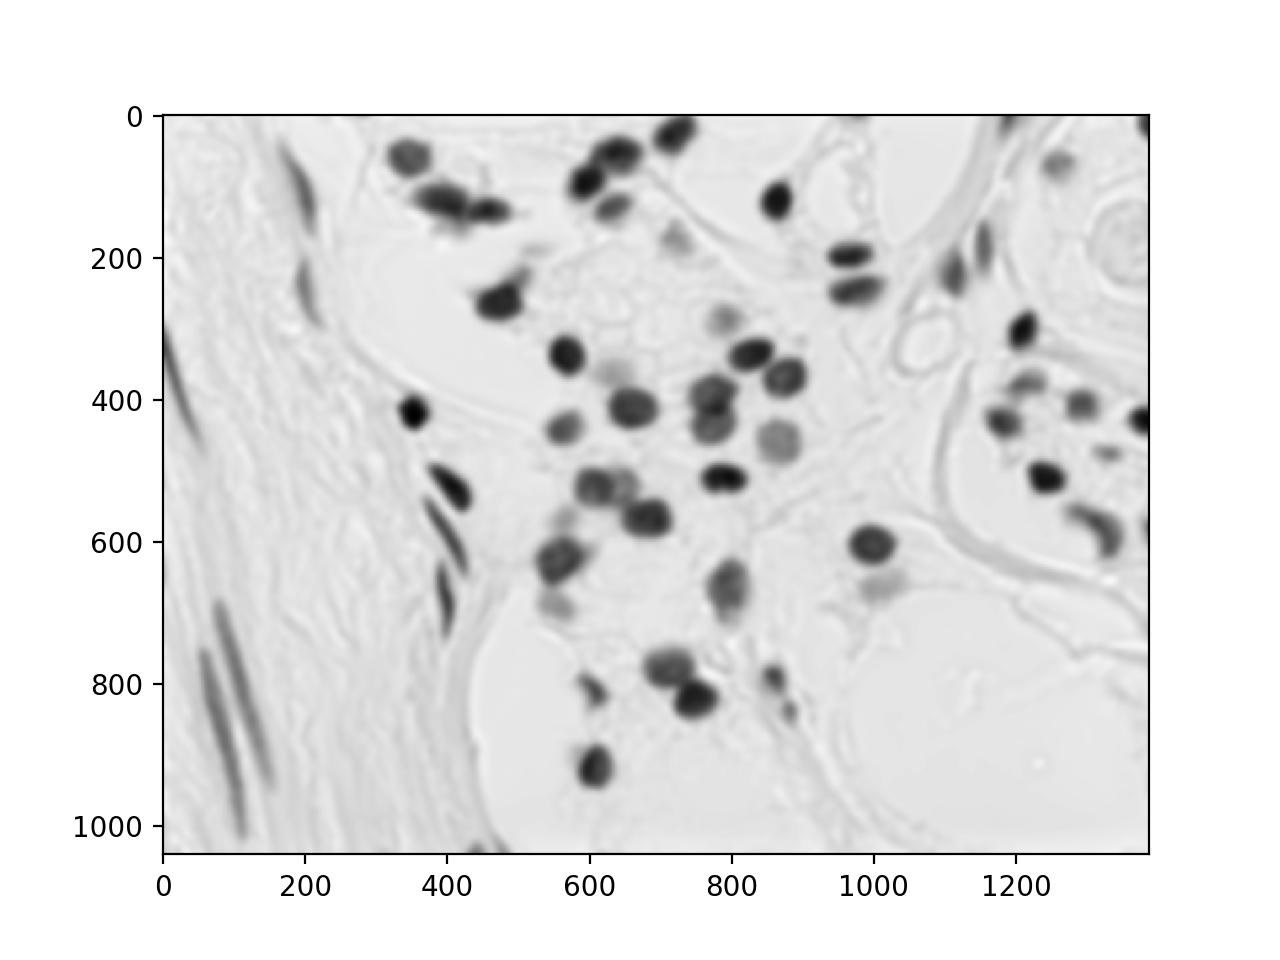

In [130]:
plt.figure()
plt.imshow(image_gauss, cmap='gray')
#print(image_gauss.shape)

In [131]:
# Definerer sobelmatrisene 
sobel_x = np.matrix('1,2,1;0,0,0;-1,-2,-1')
print(sobel_x)
sobel_y = np.matrix('1,0,-1;2,0,-2;1,0,-1')
print(sobel_y)

[[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]
[[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]


In [132]:
# Finner gradient magnitudene i x og y retning og deretter totalt 
grad_magnitude_y = convolution(image_gauss, sobel_y) 
grad_magnitude_x = convolution(image_gauss, sobel_x) 

In [133]:
# Finner den totale gradient magnituden 
grad_magnitude_tot = np.hypot(grad_magnitude_x, grad_magnitude_y)

#### Bilde av den totale gradientmagnituden 

<IPython.core.display.Javascript object>


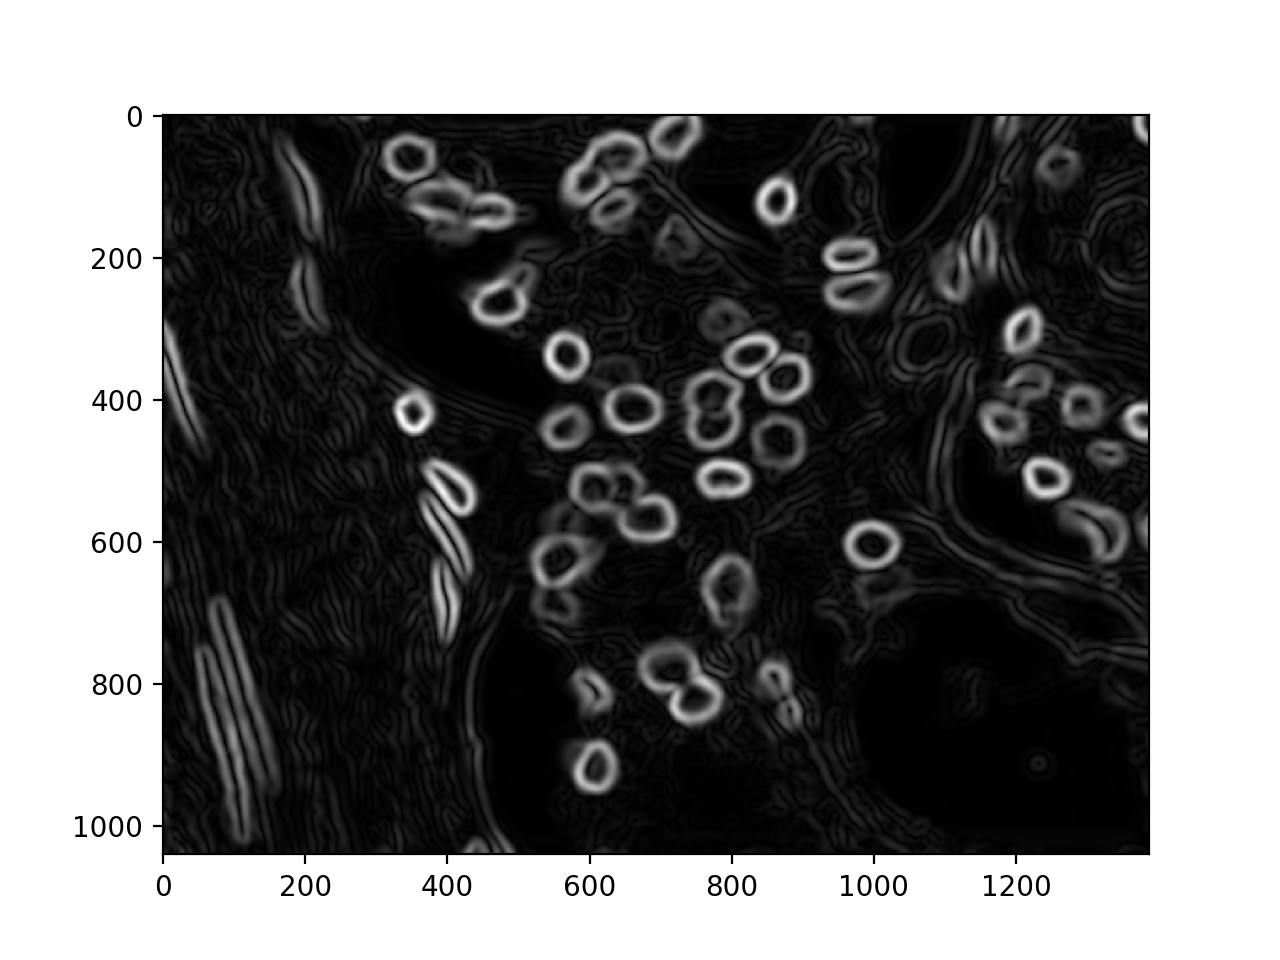

In [134]:
plt.figure()
plt.imshow(grad_magnitude_tot, cmap='gray')

#### I y-retning 

<IPython.core.display.Javascript object>


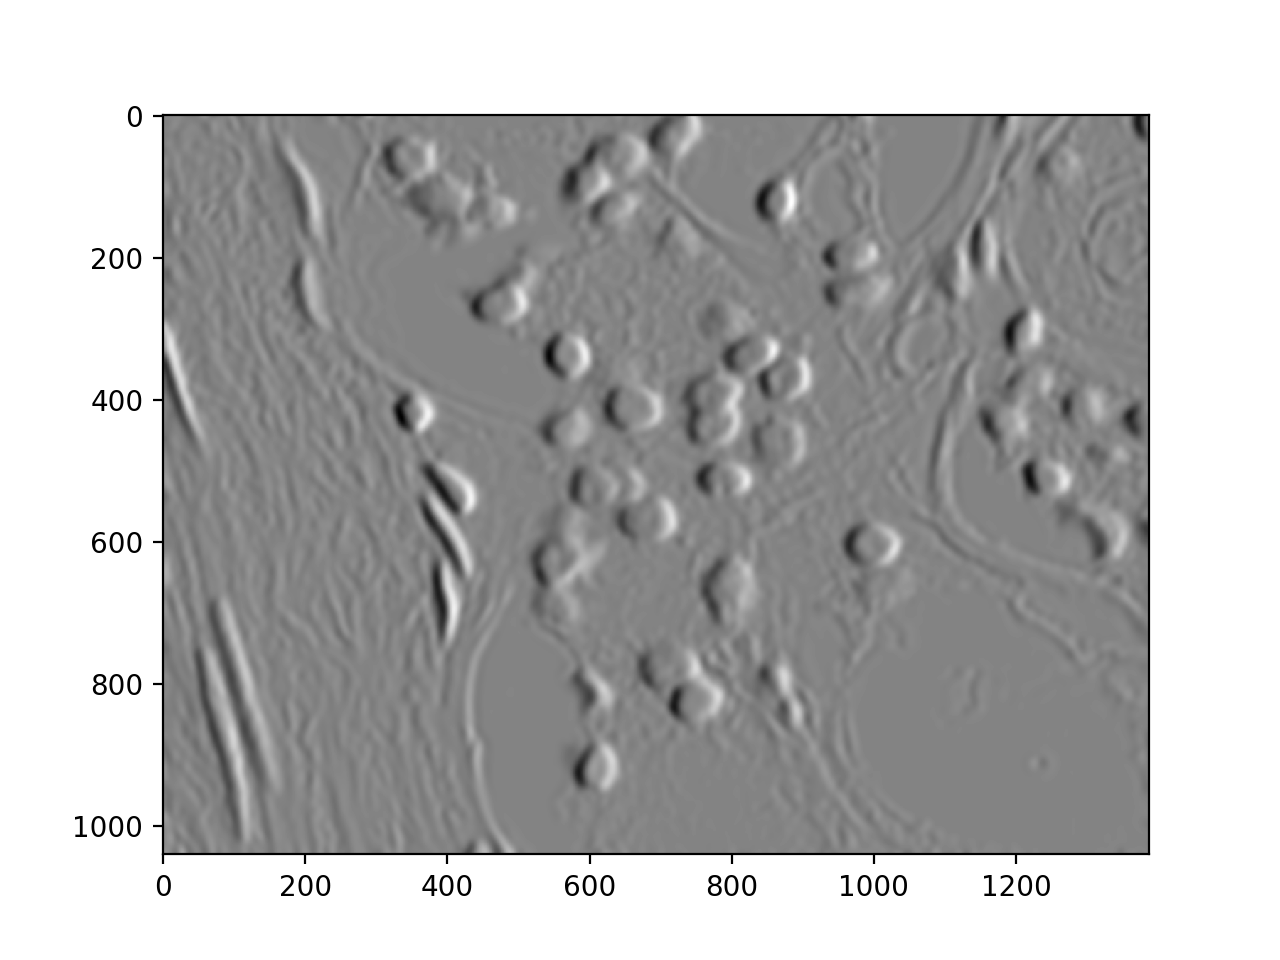

(1040, 1388)


In [135]:
plt.figure()
plt.imshow(grad_magnitude_y, cmap='gray')
print(grad_magnitude_y.shape)

#### I x-retning 

<IPython.core.display.Javascript object>


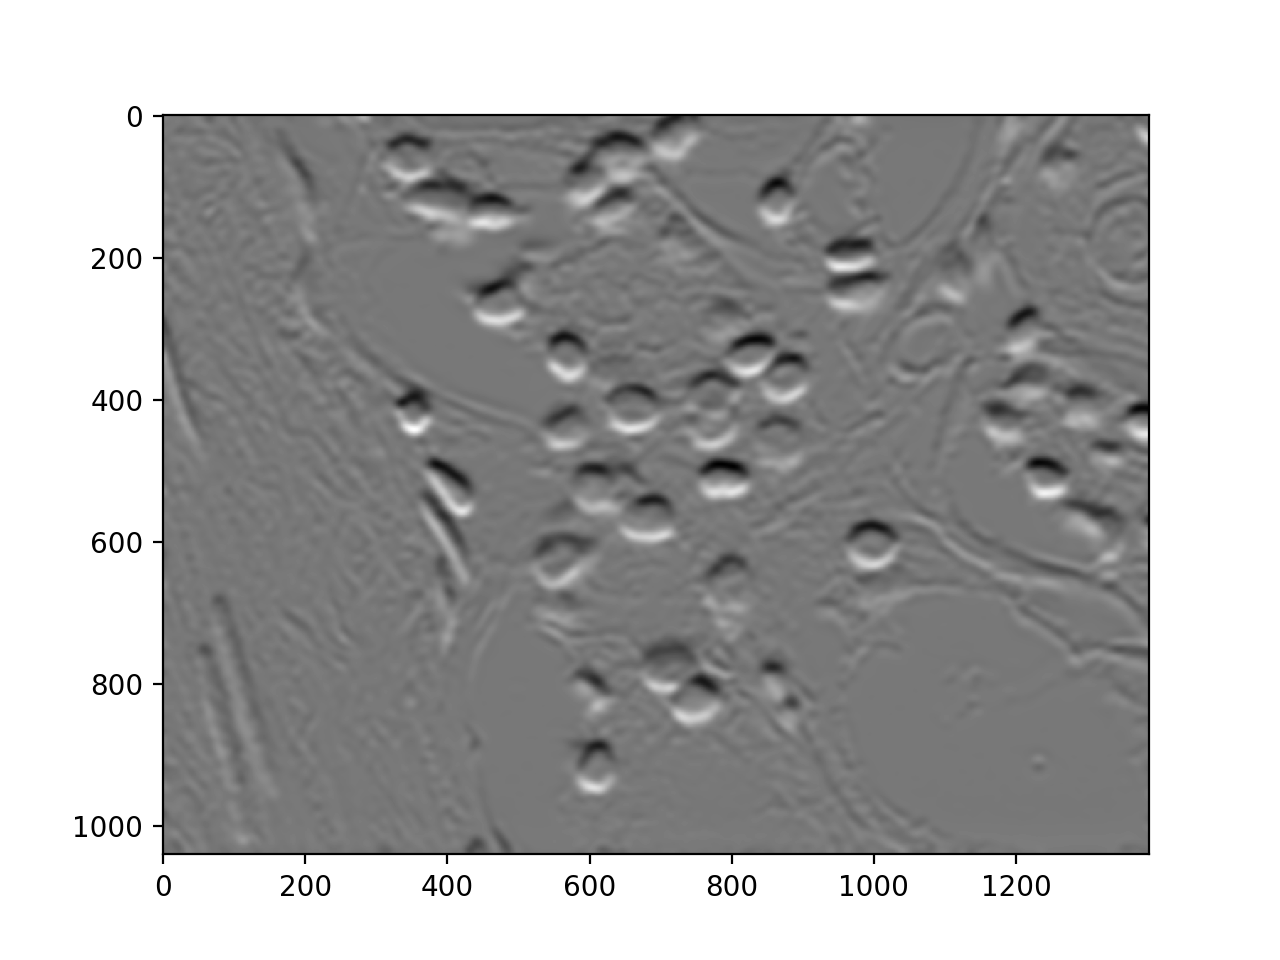

(1040, 1388)


In [136]:
plt.figure()
plt.imshow(grad_magnitude_x, cmap='gray')
print(grad_magnitude_x.shape)

In [137]:
# Finner gradientens vinkel: 
grad_magnitude_angle = np.arctan2(grad_magnitude_y,grad_magnitude_x)

#### Bilde av vinkelgradientene 

<IPython.core.display.Javascript object>


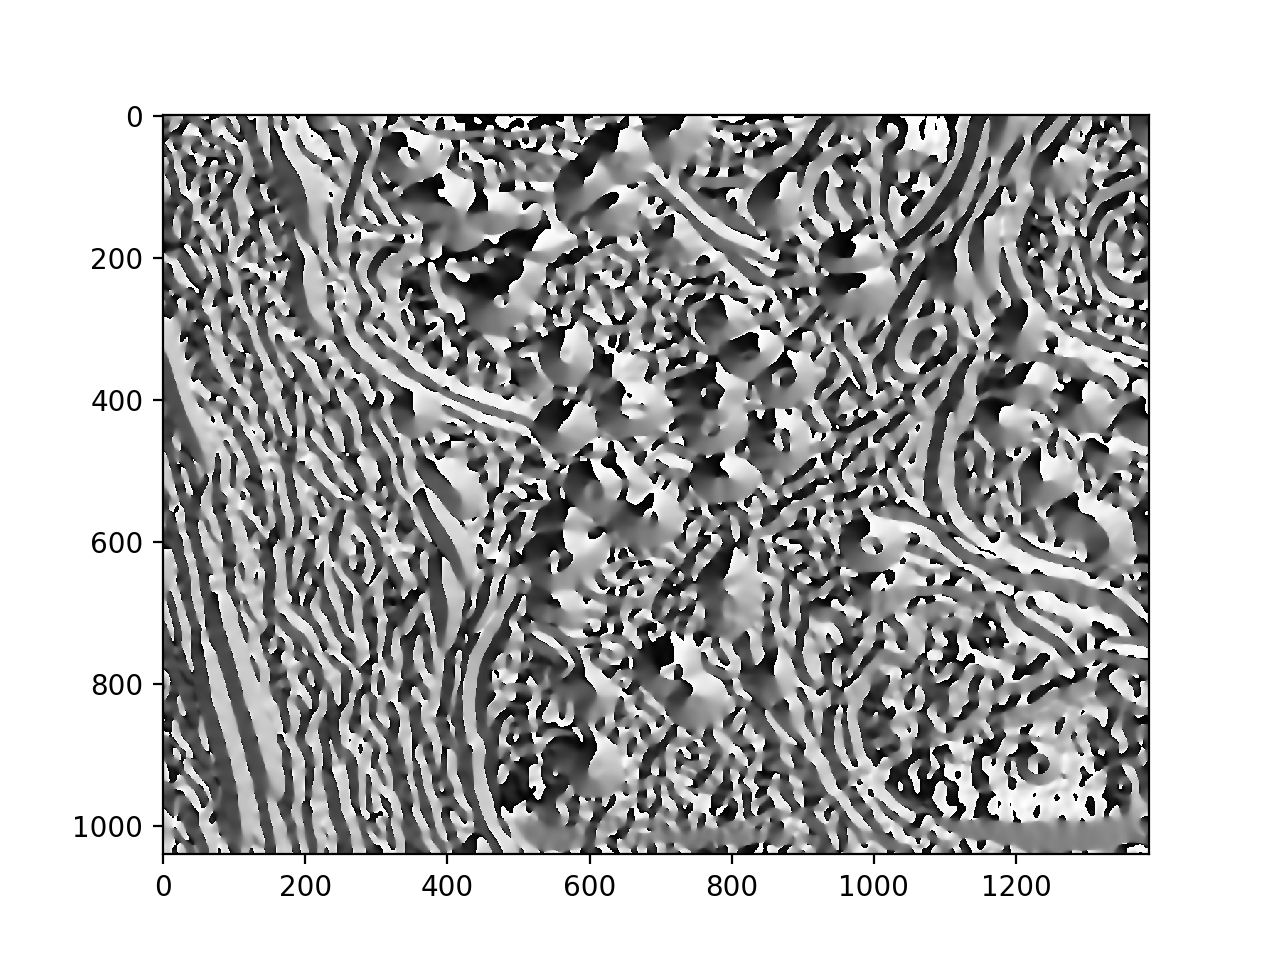

(1040, 1388)


In [138]:
plt.figure()
plt.imshow(grad_magnitude_angle, cmap='gray')
print(grad_magnitude_angle.shape)

### Normaliserer alle vinkelgradientene til absoluttverdi og å peke i retning av kantene: 

Finner absoluttverdien til alle gradientene og at de peker i samme retning som kantene, altså normalt på opprinnnelig gradient. 


In [139]:
#Normaliserer alle gradientene: 
# Snur gradientene, slik at de peker mot kantens retning istedet 
def normGradAngle(grad_angle):
    M,N = grad_angle.shape
    grad_angle_new = np.zeros((M,N))
    for i in range(0,M): 
        for j in range(0,N):
            grad_angle_new[i,j] = round(grad_angle[i,j]*(180/(45*math.pi))*45) % 180
    return grad_angle_new

<IPython.core.display.Javascript object>


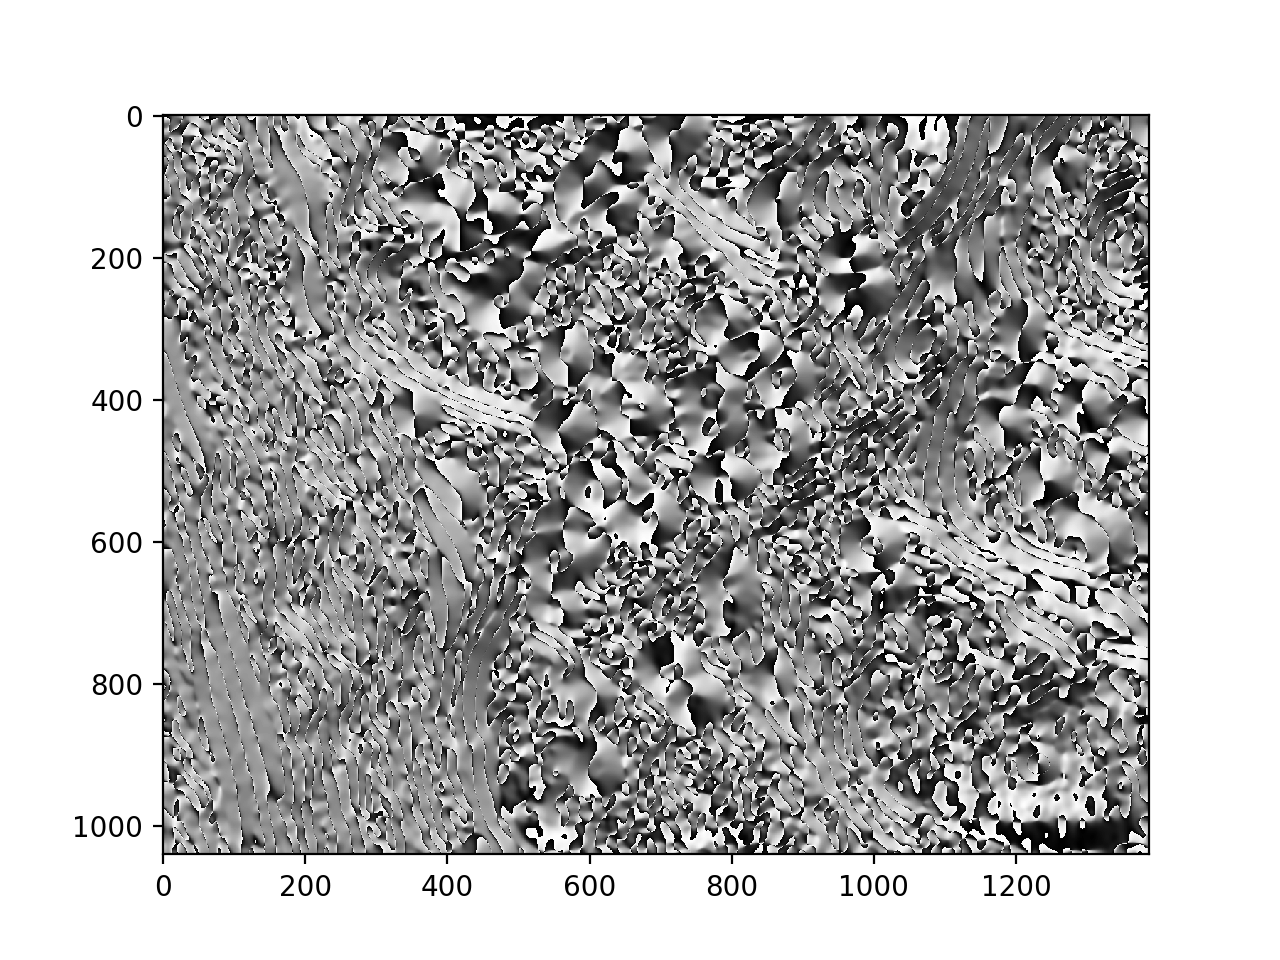

(1040, 1388)


In [140]:
plt.figure()
plt.imshow(normGradAngle(grad_magnitude_angle), cmap='gray')
print(grad_magnitude_angle.shape)

#### Tynner kantene: 
Bruker gradene som peker med retningen til kanten, dvs at vi må bruke de nabopikslene som peker normalt på denne retningen. 

In [141]:
#@numba.jit(nopython=True,parallel=True)#(nopython=True, parallel=True) 
def thin_grad_magnitude(grad_tot, grad_angle):

    M,N = grad_tot.shape
    #pad med 1 piksels ramme for enkelt å finne alle naboer
    grad_tot_pad = np.zeros((M+2,N+2))
    grad_angle_pad = np.zeros((M+2,N+2))
    
    # angir naboene: 
    nabo = np.zeros((3,3))
    
    # matrise som tar ut de med samme retning:  
    maske_retning = np.zeros((3,3))
    
    grad_tot_pad[1:M+1,1:N+1] = grad_tot[:,:]
    grad_angle_pad[1:M+1,1:N+1] = grad_angle[:,:]
    
    grad_out_thin = np.zeros((M,N))
    
    #itererer over opprinnelig gradientbilde, uten rammen. 
    for i in range(1,M+1): 
        for j in range(1,N+1): 
            
            # Henter 8-naboskapsmasken 
            nabo = grad_angle_pad[i-1:i+2, j-1:j+2]
            # Sjekker vinkelen i kantvinkelgradientbildet. (grad_angle_pad)
            # 1. Vinklene deles inn i 4 retninger: 0,45, 90 og 135. 
            # 2. finner de vinklene som kan karakteriseres som 90 grader på kantvinkelen. (opprinnelig gradientvinkel)
            # 3. Lager maske som plukker ut de naboene som er i området som er normalt på kantvinkelen. 
            # 4. bruker masken på gradient bildet. sjekker hvilken magnituden som er sterkest 
            #    og om ikke magnituden som sjekkes, er størst så blir denne magnituden satt til 0. Ellers beholdes magnitudeverdien, i den nye tynnede matrisen.
            #a = grad_angle_pad[i,j]
            if grad_angle_pad[i,j] > 23 and grad_angle_pad[i,j] < 69: 
                #absolutt verdi av vinkelen er enten 0 eller 180 grader 
                #sjekk magnituden normalt på: 
                # lager en maske som henter ut naboverdiene som står normalt på i magnitude matrisen 
                maske_retning = np.matrix('1,0,0;0,1,0;0,0,1')
                maske_retning = np.multiply(maske_retning[:,:], grad_tot_pad[i-1:i+2, j-1:j+2]) 
                # sjekk hvilken som er max og bestemmer utbildets intensitet.
                if grad_tot_pad[i,j] == np.max(maske_retning): #max_magnitude: 
                    grad_out_thin[i-1,j-1] = grad_tot_pad[i,j] 
                else: 
                    grad_out_thin[i-1,j-1] = 0 
                    
            elif grad_angle_pad[i,j] > 68 and grad_angle_pad[i,j] < 114: 
                maske_retning = np.matrix('0,0,0;1,1,1;0,0,0')
                maske_retning = np.multiply(grad_tot_pad[i-1:i+2, j-1:j+2],maske_retning) 
                if grad_tot_pad[i,j] == np.max(maske_retning):
                    grad_out_thin[i-1,j-1] = grad_tot_pad[i,j] 
                else: 
                    grad_out_thin[i-1,j-1] = 0 
                    
            elif grad_angle_pad[i,j] > 113 and grad_angle_pad[i,j] < 159: 
                maske_retning = np.matrix('0,0,1;0,1,0;1,0,0')
                maske_retning = np.multiply(grad_tot_pad[i-1:i+2, j-1:j+2] , maske_retning)
                if grad_tot_pad[i,j] == np.max(maske_retning):
                    grad_out_thin[i-1,j-1] = grad_tot_pad[i,j]                     
                else: 
                    grad_out_thin[i-1,j-1] = 0 

            elif grad_angle_pad[i,j] < 24 or grad_angle_pad[i,j] > 158: 
                maske_retning = np.matrix('0,1,0;0,1,0;0,1,0')
                maske_retning = np.multiply(grad_tot_pad[i-1:i+2, j-1:j+2],maske_retning)
                if grad_tot_pad[i,j] == np.max(maske_retning): #max_magnitude: 
                    grad_out_thin[i-1,j-1] = grad_tot_pad[i,j] 
                else: 
                    grad_out_thin[i-1,j-1] = 0 

    return grad_out_thin    

In [142]:
grad_tot_thin = thin_grad_magnitude(grad_magnitude_tot,normGradAngle(grad_magnitude_angle))

<IPython.core.display.Javascript object>


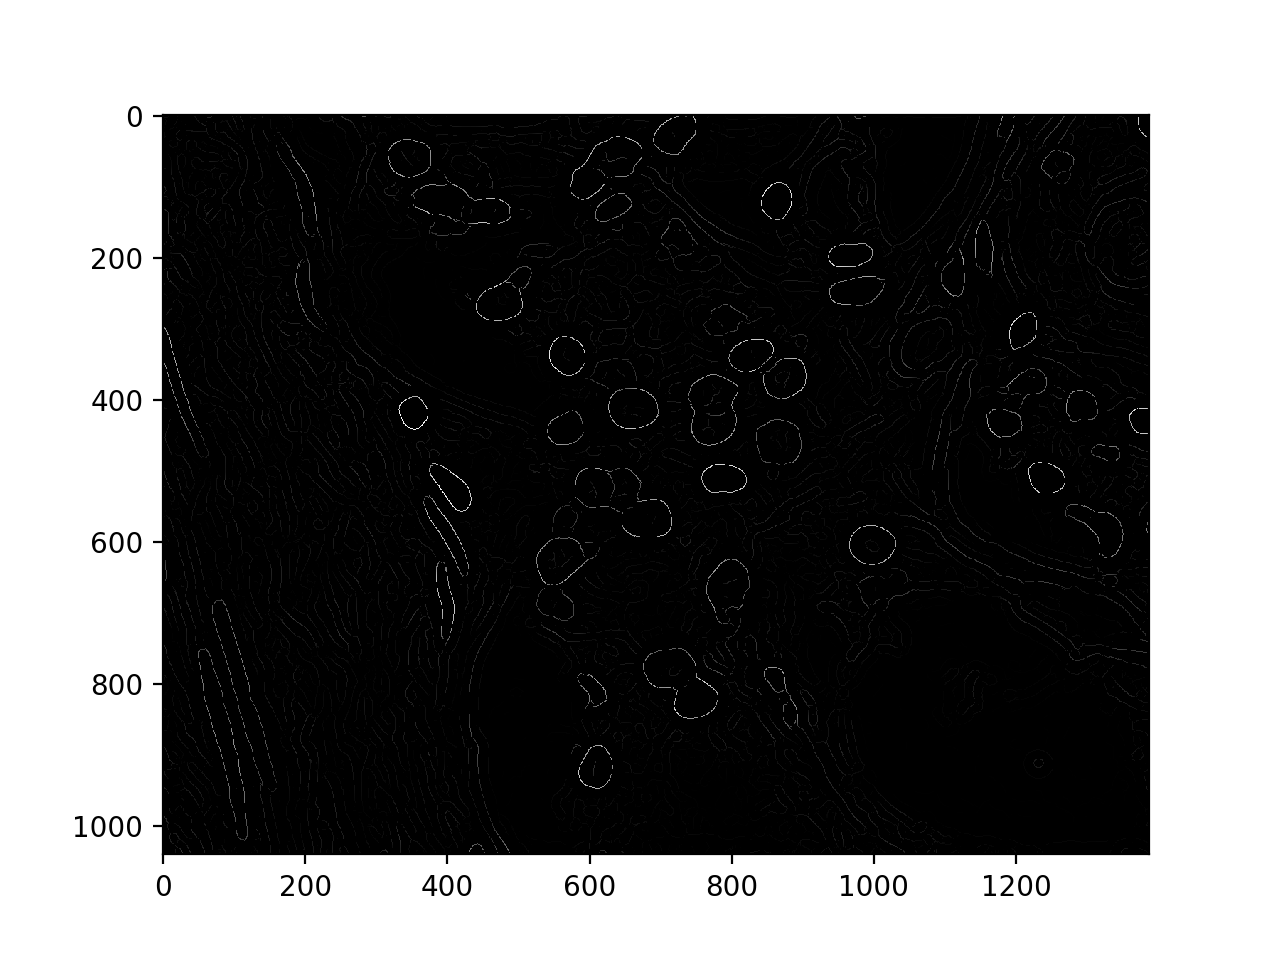

91.73296787427651


In [143]:
plt.figure()
plt.imshow(grad_tot_thin, cmap='gray')
print(np.max(grad_tot_thin))

### Oppgave 2c) Terskle det tynnede magnitude bildet.  
Ved bruk av hystereseterskling. Skal fjerne de svakeste, og beholde de sterkeste. De som er midt i mellom skal sjekkes om de har en sterk nabo, om de har skal denne også beholdes. Tilslutt vil man fjerne de svake som er lenket sammen, men som ikke har en eneste sterk nabo i lenken.  

In [144]:
#@numba.jit(nopython=True, parallel=True) #(parallel=True)
def terskel(grad_magnitude_thin, th, tl):
    
    M,N = grad_magnitude_thin.shape
    
    #normaliserer input bildet
    grad_magnitude_thin = grad_magnitude_thin/np.max(grad_magnitude_thin)*255
    #print(np.max(grad_magnitude_thin))    
    # setter på ramme på det tynnede bildet for å finne naboene enkelt 
    grad_thin_pad = np.zeros((M+2,N+2))
    grad_thin_pad[1:M+1,1:N+1] = grad_magnitude_thin[:,:]
    
    # definerer nabomasken 
    nabo = np.zeros((3,3))

    # outputbildet: 
    grad_magnitude_thin_terskel = np.zeros((M,N))
    
    teller = 0
    
    # 1. itererer igjennom innbildet, og merker utbildet med 1, 0, 0.2
   
    # 2. teller antall piksler som blir merket med 0.2. 
    # 3. Disse er svake piksler og må sjekkes om de er i nærheten av sterke piksler.  
    # 4. Når ingen endringer har skjedd fra siste loop til neste settes alle 0.2 = 0
    for i in range(1,M+1):
        for j in range(1,N+1): 
            if grad_thin_pad[i,j] > th:
                grad_magnitude_thin_terskel[i-1,j-1] = 1
            elif grad_thin_pad[i,j] < tl: 
                grad_magnitude_thin_terskel[i-1,j-1] = 0
            else: 
                grad_magnitude_thin_terskel[i-1,j-1] = 0.2
                teller = teller + 1
    print(teller)
    
    # Pad for å finne nabopikslene enklest
    grad_magnitude_thin_terskel_pad = np.zeros((M+2,N+2))
    grad_magnitude_thin_terskel_pad[1:M+1,1:N+1] = grad_magnitude_thin_terskel[:,:]
    
    # Sjekker om alle er endret 
    pikselEndret = True 
    
    #Finner svake piksler
    svakePikslerFinnes = np.any(grad_magnitude_thin_terskel_pad[:, :] == 0.2)
    
    # Om matrisen inneholder 0.2 og pikslene har blitt endret siden sist: 
    while svakePikslerFinnes and pikselEndret:        
        # settes til false slik at om det ikke skjer en endring vil man hoppe ut av loopen 
        pikselEndret = False

        for i in range(1,M+1):
            for j in range(1,N+1): 
                # Går igjennom terskelmatrisen: 
                if grad_magnitude_thin_terskel_pad[i,j] == 0.2: 
                    # Henter 8-naboskapsmasken 
                    nabo = grad_magnitude_thin_terskel_pad[i-1:i+2, j-1:j+2] - np.matrix('0,0,0;0,-0.2, 0; 0,0,0')
                    if np.max(nabo) == 1:
                        grad_magnitude_thin_terskel_pad[i,j] = 1
                        pikselEndret = True 
                    elif np.max(nabo) == 0:
                        grad_magnitude_thin_terskel_pad[i,j] = 0
                        pikselEndret = True 
                    else: 
                        grad_magnitude_thin_terskel_pad[i,j] = 0.2
  
        svakePikslerFinnes = np.any(grad_magnitude_thin_terskel_pad[:, :] == 0.2)
    # Setter alle 
    grad_magnitude_thin_terskel_pad = np.where(grad_magnitude_thin_terskel_pad < 1, 0, 1)
    
    return grad_magnitude_thin_terskel_pad

### Kantdetektor 

In [155]:
tersk3 = terskel(grad_tot_thin, 85,35)

11900


<IPython.core.display.Javascript object>


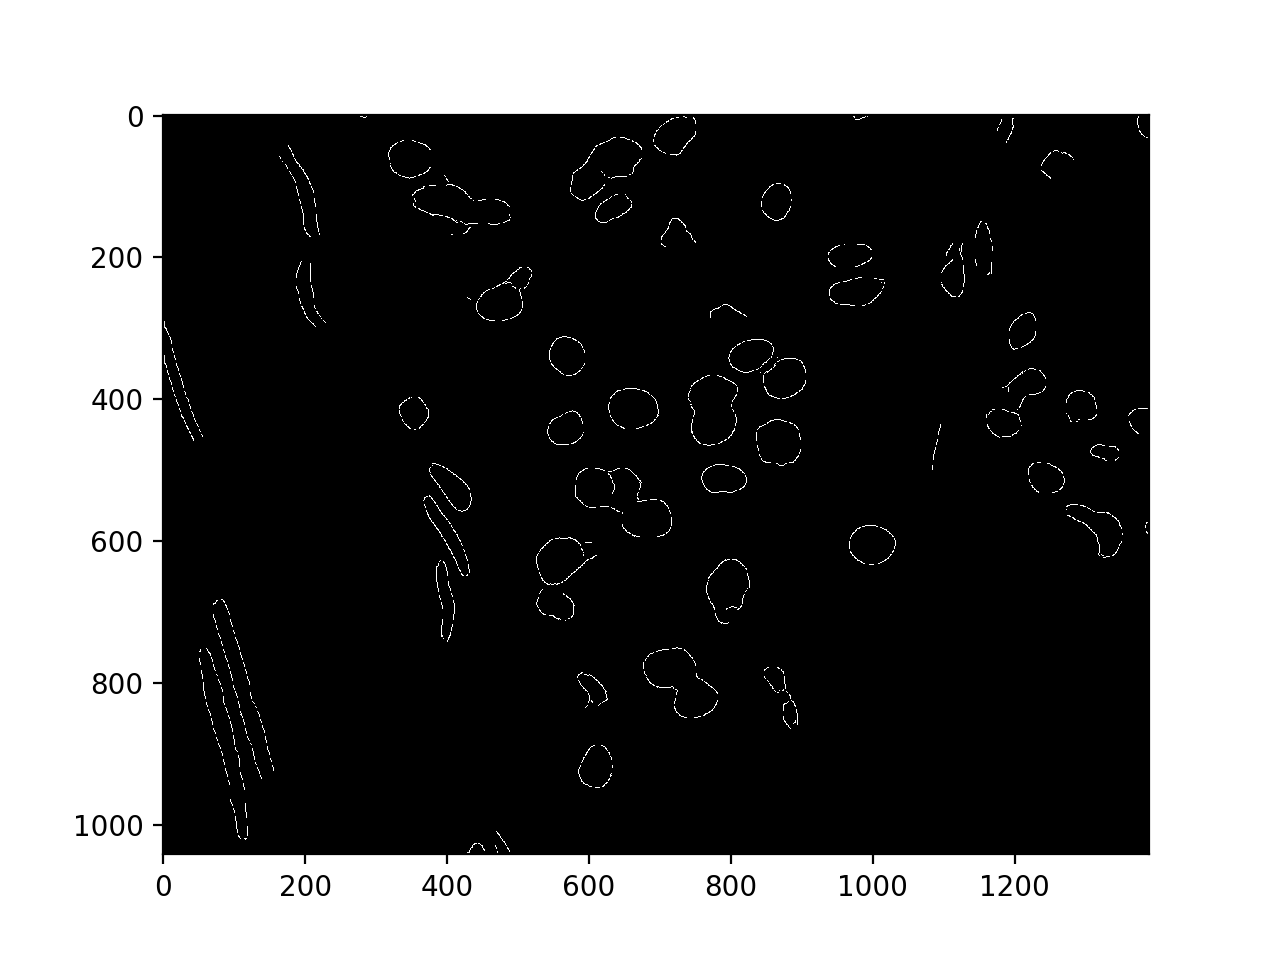

In [148]:
# sigma = 6 - 85,60
plt.figure()
plt.imshow(tersk3, cmap='gray')

<IPython.core.display.Javascript object>


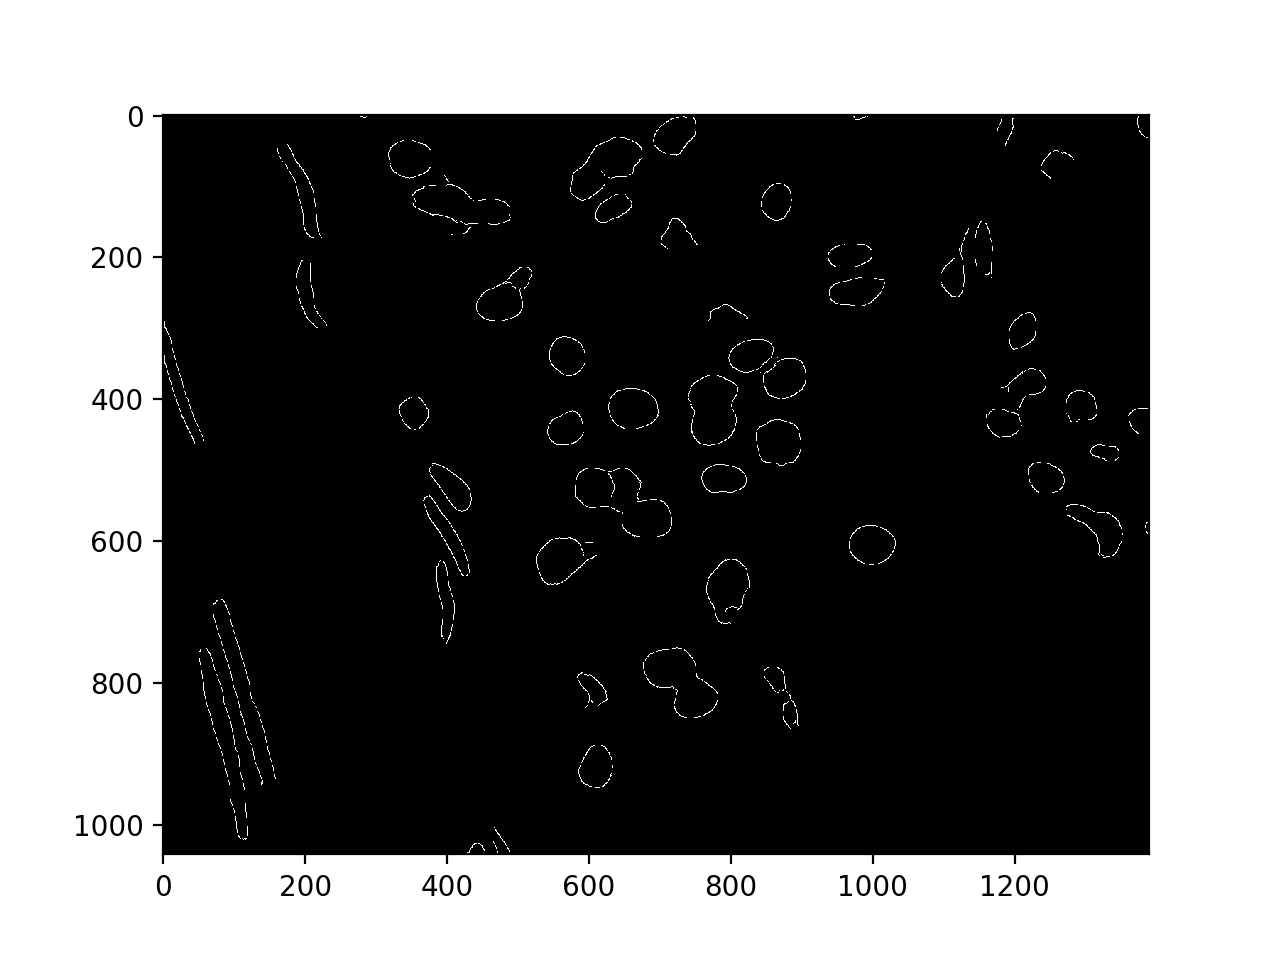

In [150]:
# sigma 6- 85,50
plt.figure()
plt.imshow(tersk3, cmap='gray')

<IPython.core.display.Javascript object>


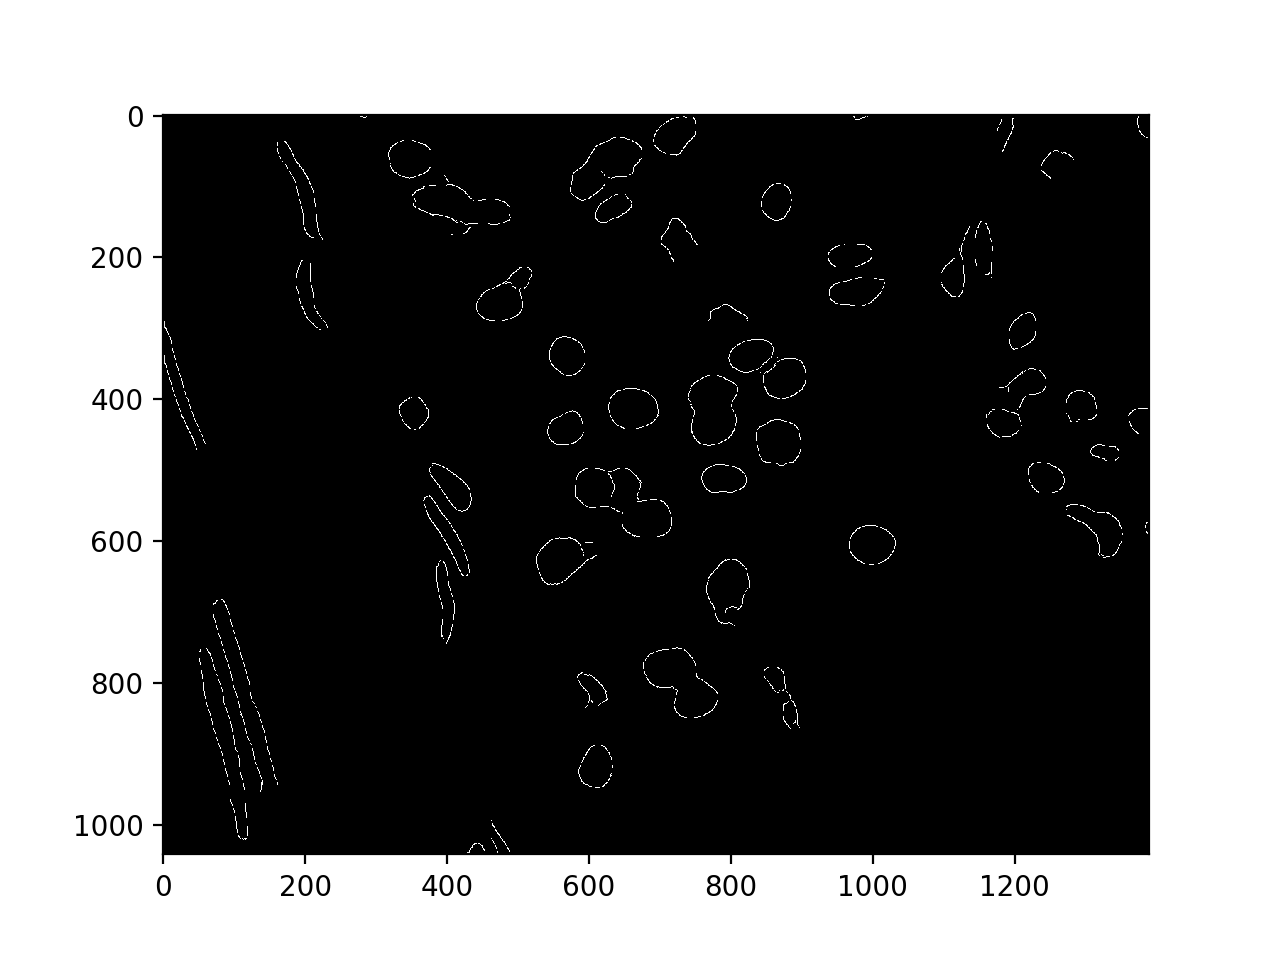

In [152]:
# sigma 6- 85,40
plt.figure()
plt.imshow(tersk3, cmap='gray')

<IPython.core.display.Javascript object>


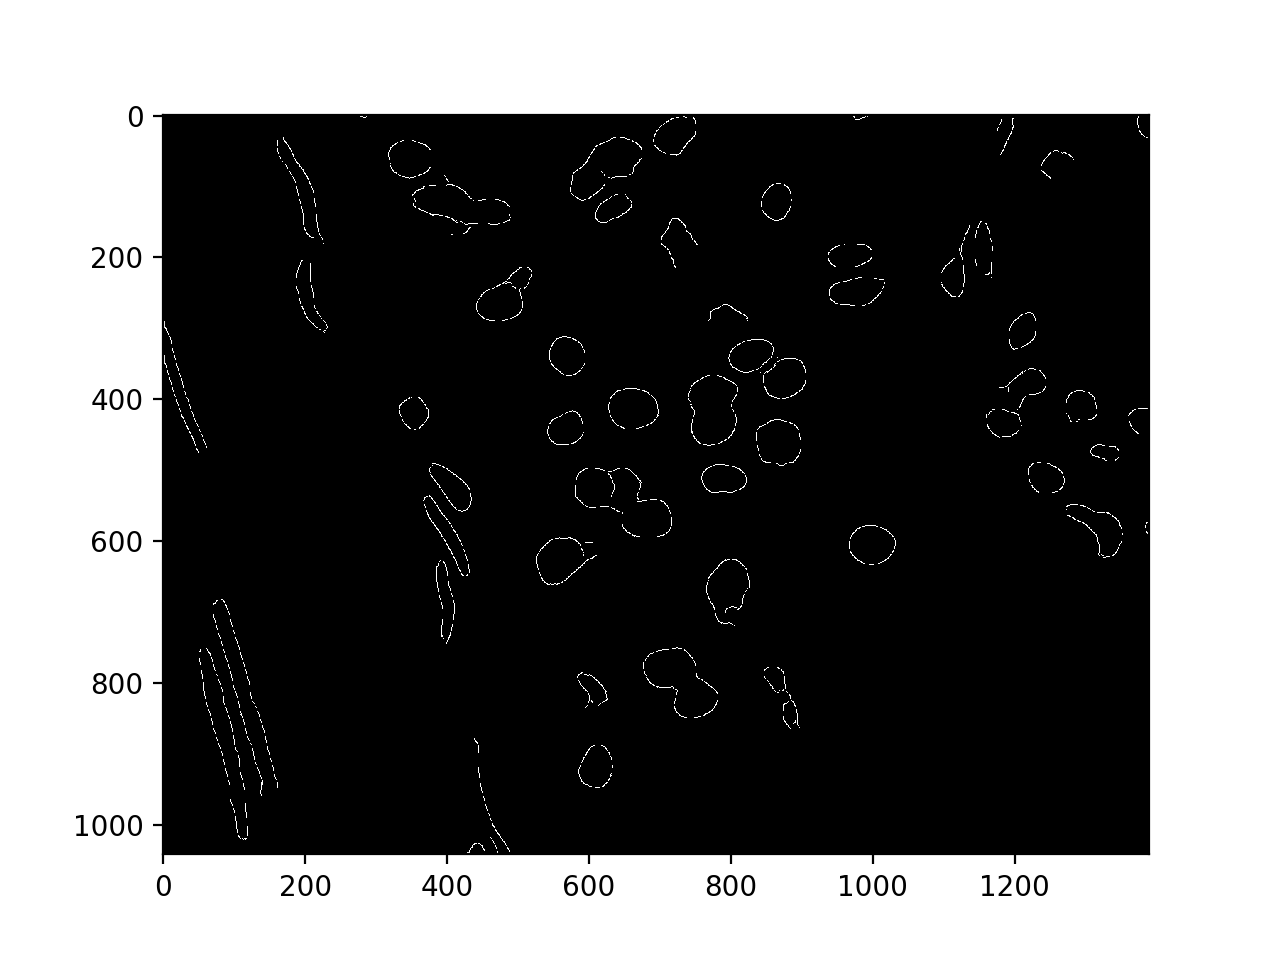

In [156]:
# sigma 6- 85,35
plt.figure()
plt.imshow(tersk3, cmap='gray')

<IPython.core.display.Javascript object>


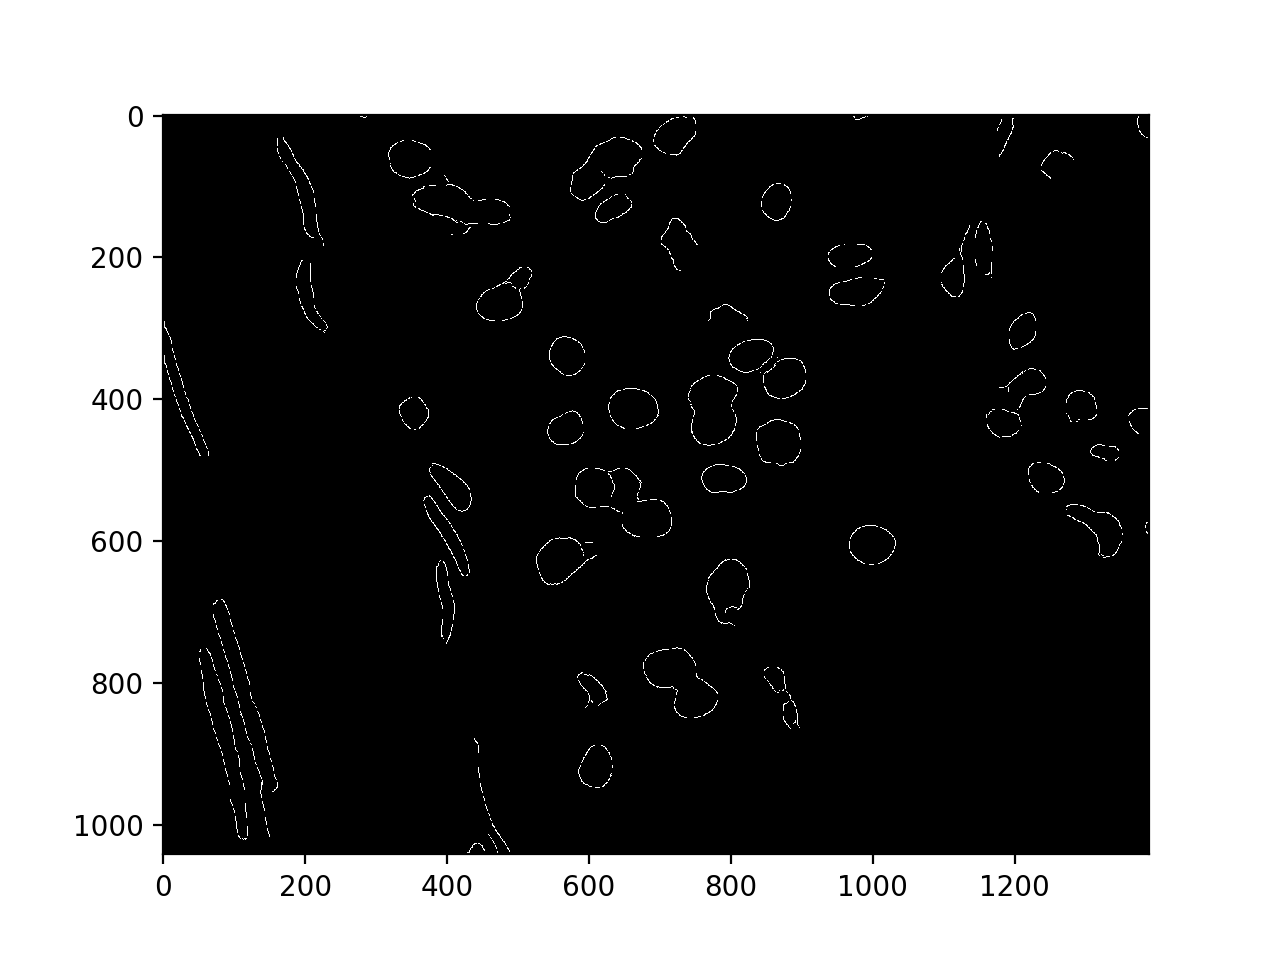

In [154]:
# sigma 6- 85,30
plt.figure()
plt.imshow(tersk3, cmap='gray')

In [110]:
tersk2 = terskel(grad_tot_thin, 85,55) 

4897


<IPython.core.display.Javascript object>


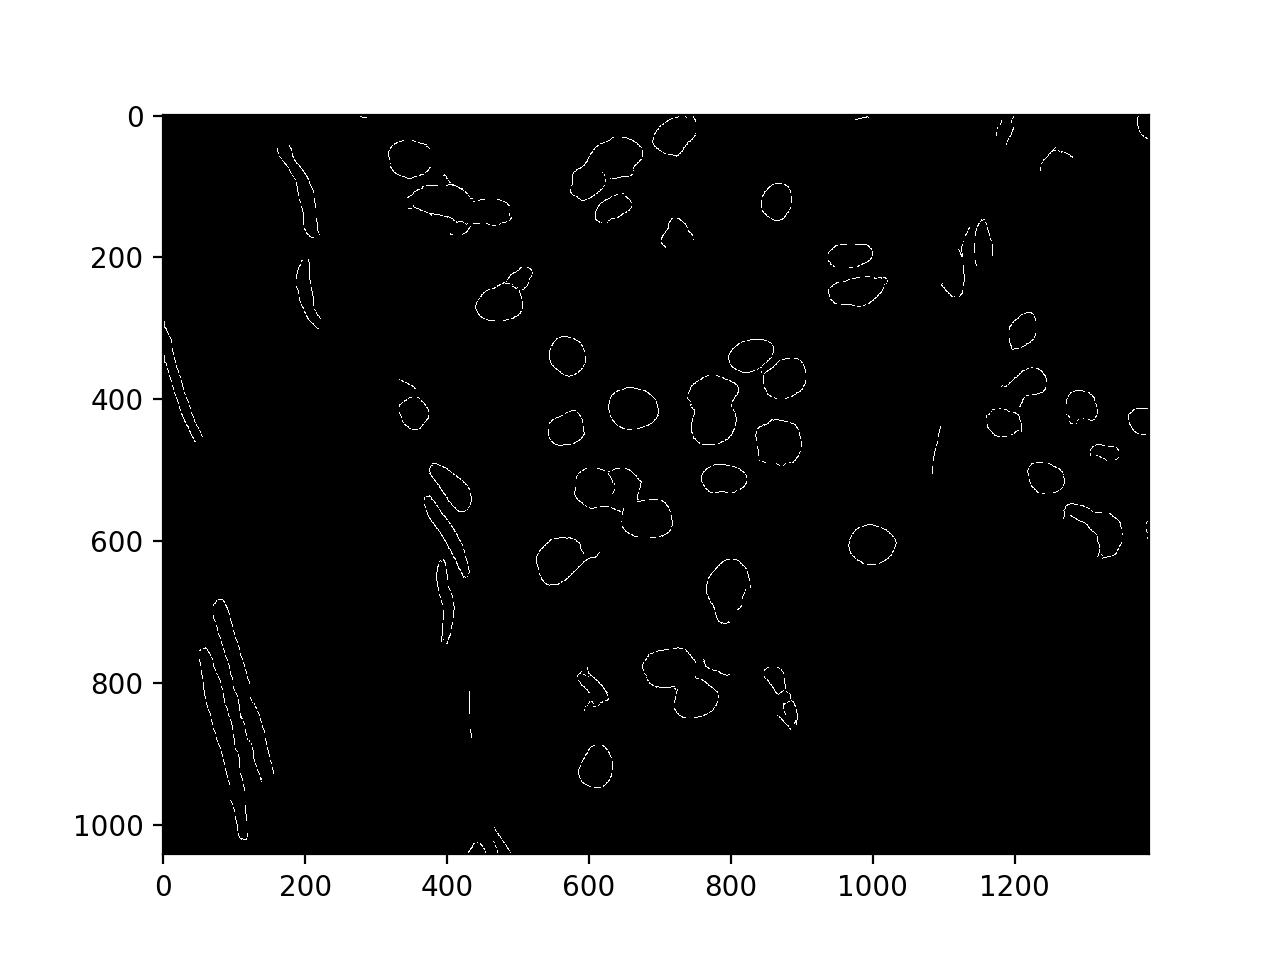

In [111]:
# sigma 5- 85,55
plt.figure()
plt.imshow(tersk2, cmap='gray')

<IPython.core.display.Javascript object>


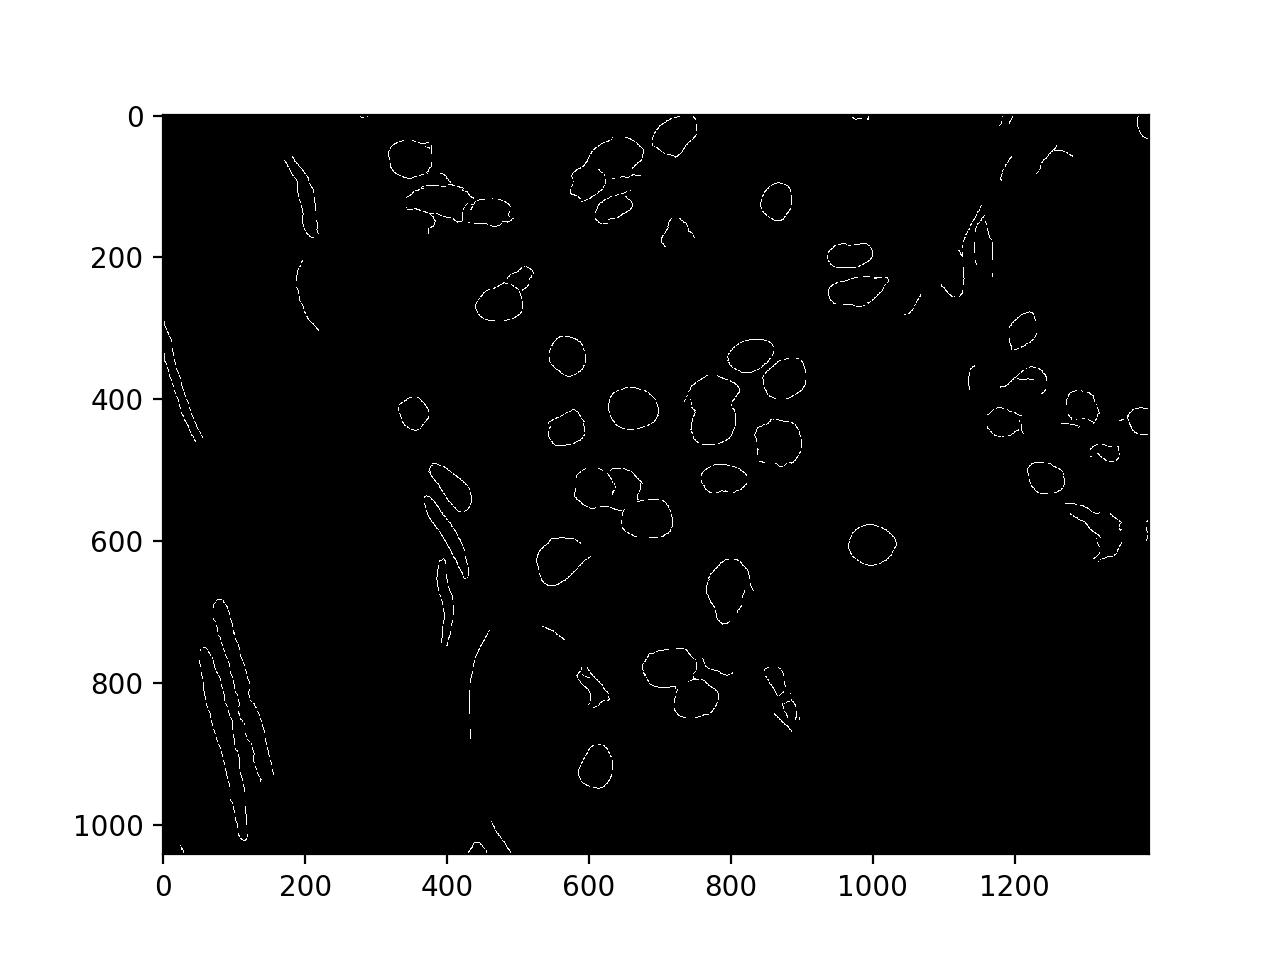

In [161]:
# 41,41,5- 50,40
plt.figure()
plt.imshow(tersk, cmap='gray')

In [114]:
tersk = terskel(grad_tot_thin, 90,50)

255.0
11099


<IPython.core.display.Javascript object>


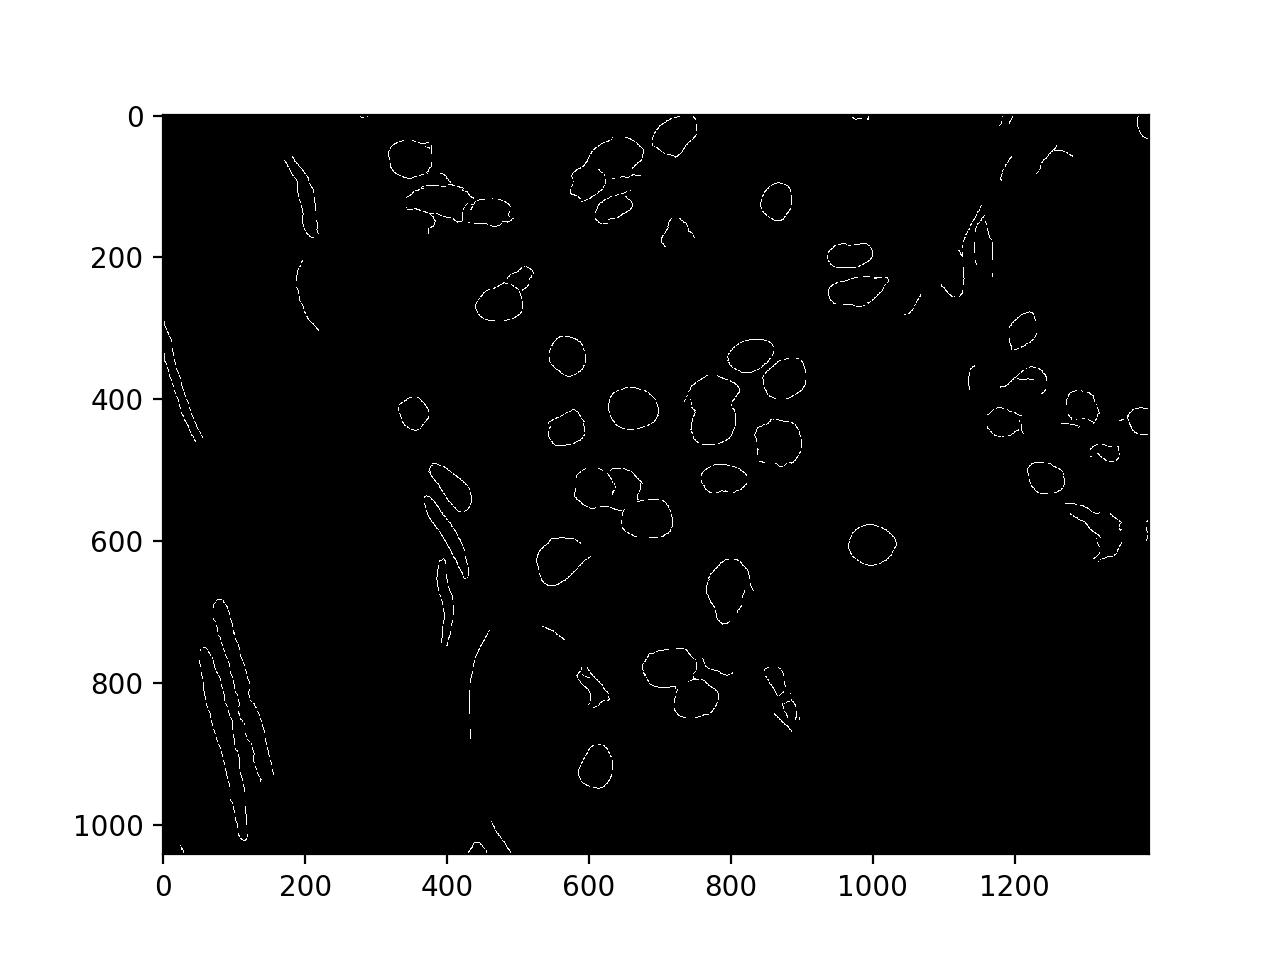

In [115]:
# 33,33,4- 90,50
plt.figure()
plt.imshow(tersk, cmap='gray')

<IPython.core.display.Javascript object>


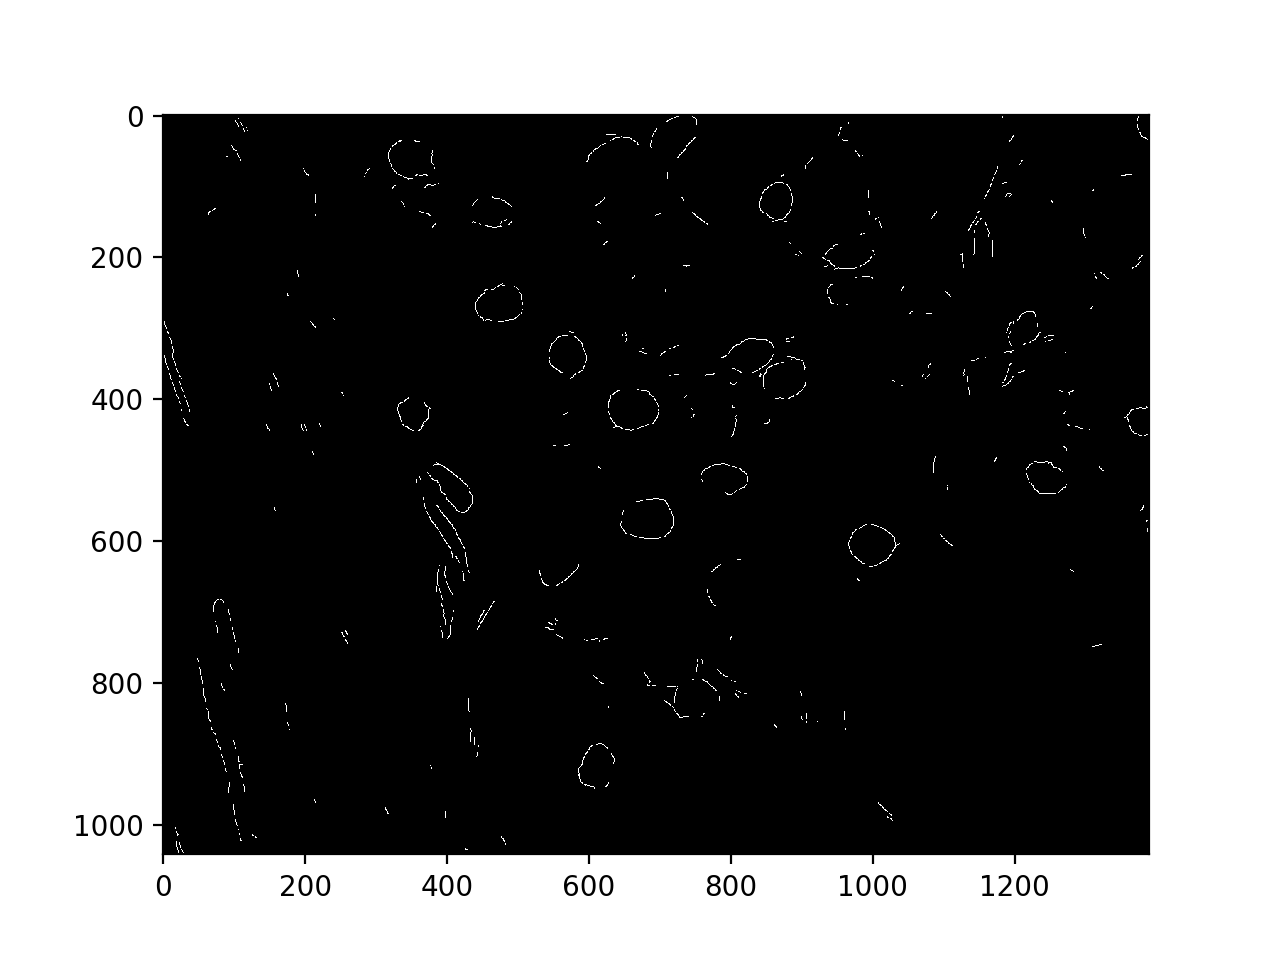

In [74]:
# 11,11,1.25- 100,80 
plt.figure()
plt.imshow(tersk, cmap='gray')

<IPython.core.display.Javascript object>


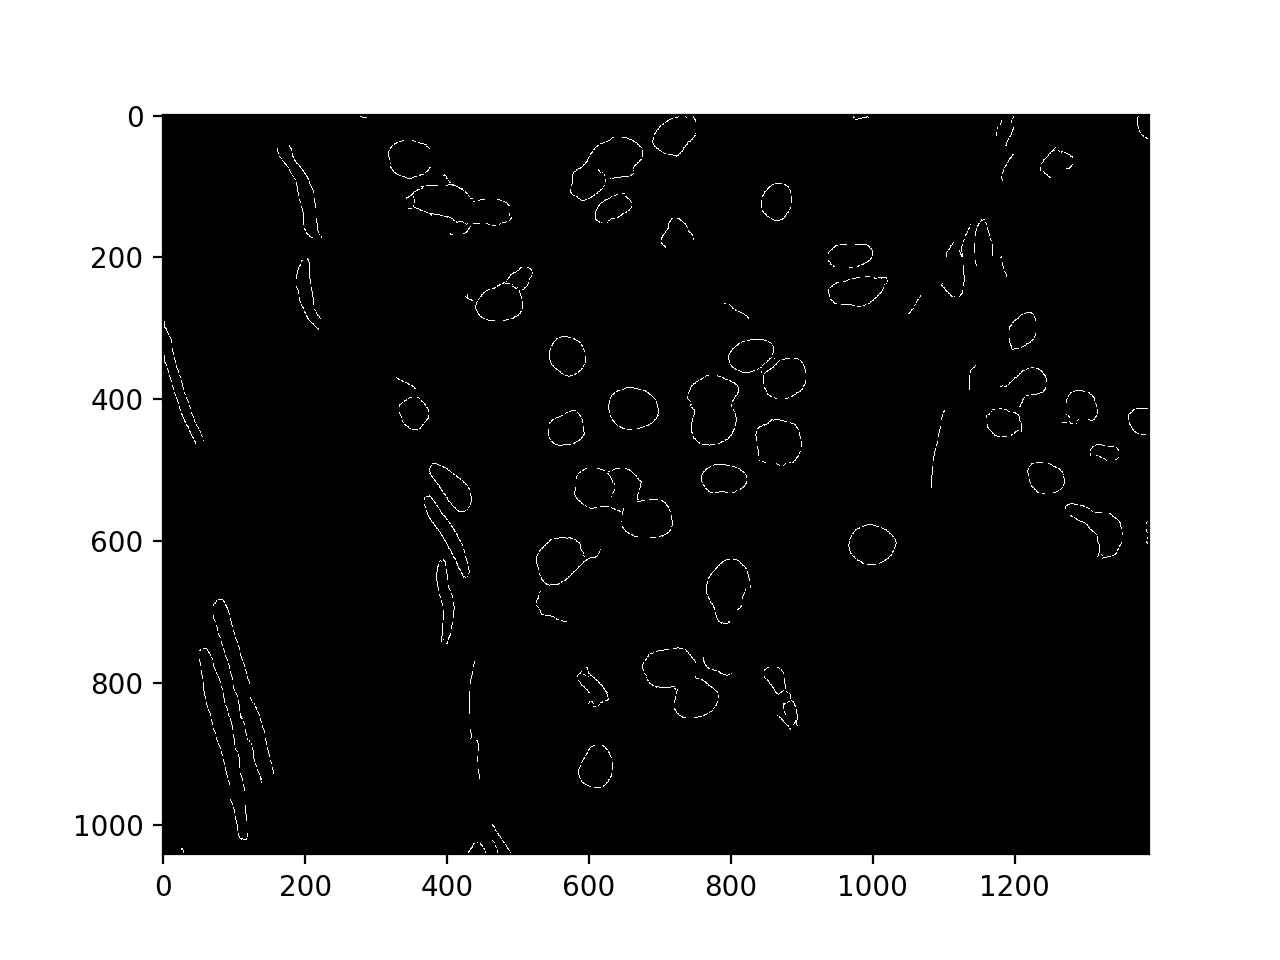

In [36]:
# 31,31,5- 80,50 
plt.figure()
plt.imshow(tersk, cmap='gray')